In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


## Import Libraries

In [98]:
import matplotlib.pyplot as plt
import splitfolders
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [99]:
print(f"numpy version used:{np.__version__}")
print(f"tensorflow version used:{tf.__version__}")

numpy version used:1.23.5
tensorflow version used:2.12.0


## Creating Directory

In [100]:
path_dir=('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

train_dir=os.path.join(path_dir,'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

for folder in os.listdir(train_dir):
    folder_path=os.path.join(train_dir,folder)
    print(f"Number of images in {folder}:{len(os.listdir(folder_path))}")
    print()

Number of images in Cyst:3709

Number of images in Tumor:2283

Number of images in Stone:1377

Number of images in Normal:5077



### Plotting Data Images

In [101]:
def plot_images(image_dir,num_images):
    images_list=os.listdir(image_dir)
    images_dir_list=[os.path.join(image_dir,image) for image in images_list][:num_images]
    plt.figure(figsize=(10,10))
    for i,image_dir in enumerate(images_dir_list):
        plt.subplot(5,5,i+1)
        img=plt.imread(image_dir)
        plt.imshow(img)


### Sample CT Scan Images of Normal Kidneys

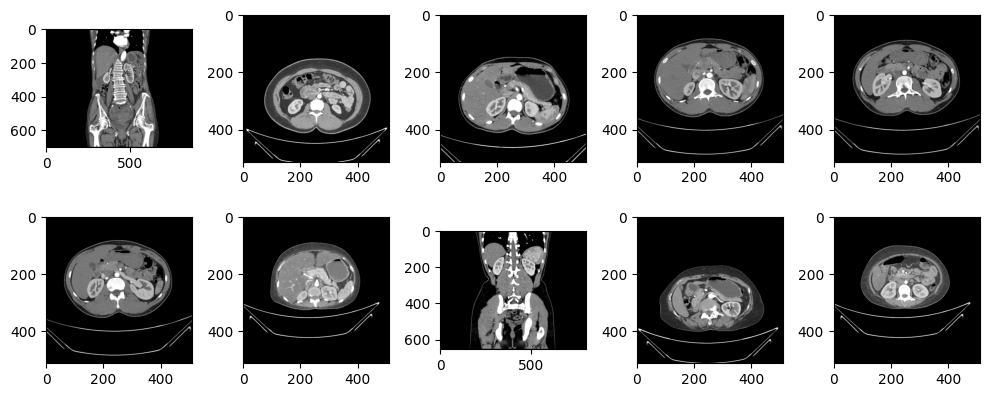

In [102]:
normal_images_dir=os.path.join(train_dir,'Normal')
plot_images(normal_images_dir,10)
plt.tight_layout()

### Sample CT Scan Images of Cyst Kidneys

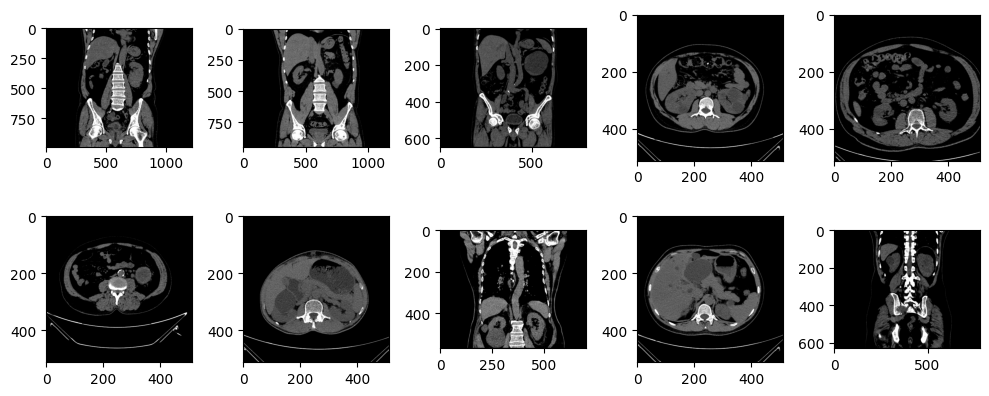

In [103]:
cyst_images_dir=os.path.join(train_dir,'Cyst')
plot_images(cyst_images_dir,10)
plt.tight_layout()

### Sample CT scan Images of Stone Kidneys

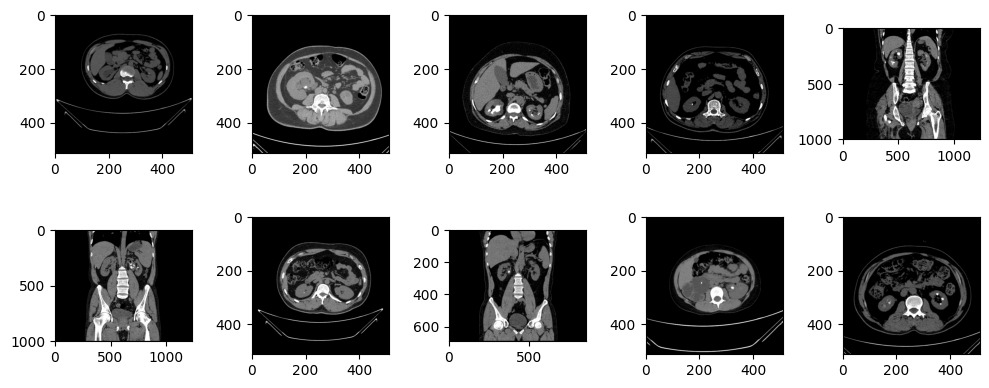

In [104]:
stone_images_dir=os.path.join(train_dir,'Stone')
plot_images(stone_images_dir,10)
plt.tight_layout()

### Sample CT-Scan Images of Tumor Kidney

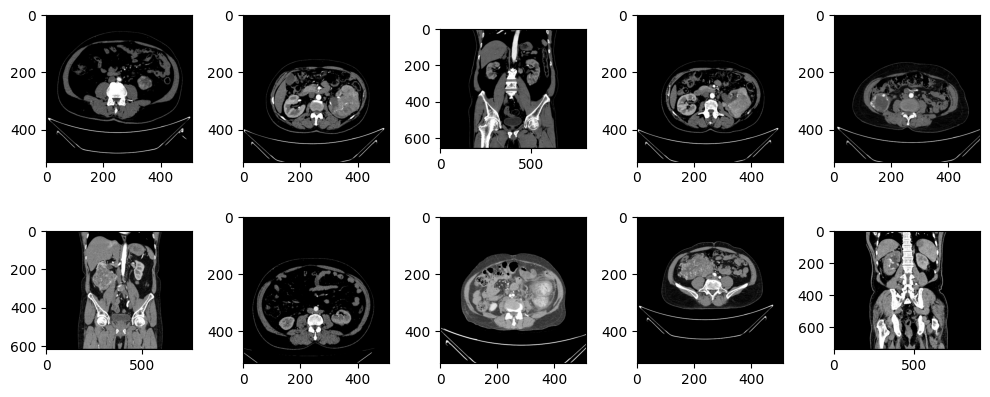

In [105]:
tumor_images_dir=os.path.join(train_dir,'Tumor')
plot_images(tumor_images_dir,10)
plt.tight_layout()

### Splitting the Dataset

In [106]:
train_datagen=ImageDataGenerator(rescale=1/255)
valid_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [107]:
!pip install split-folders

In [108]:
splitfolders.ratio(
    "../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
   output="./dataset",
   seed=10,
   ratio=(0.7,0.15, 0.15)
)

Copying files: 12446 files [00:18, 686.88 files/s] 


### Dataset loading

In [109]:
train_data=train_datagen.flow_from_directory(directory='/kaggle/working/dataset/train',
                                            target_size=(224,224),
                                            batch_size=50)
valid_data=valid_datagen.flow_from_directory(directory='/kaggle/working/dataset/val',
                                            target_size=(224,224),
                                            batch_size=50,
                                            )
test_data=test_datagen.flow_from_directory(directory='/kaggle/working/dataset/test',
                                          target_size=(224,224),
                                          batch_size=50,
                                           shuffle=False)


Found 8710 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.
Found 1871 images belonging to 4 classes.


### Model Building - VGG16

In [110]:
## Importing the Convolution Layer from VGG16
model=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    classes=4,
    classifier_activation='softmax')

In [111]:
## function to add the fully-connected layer into my convoltion layer of VGG16
def prepare_full_model(model,freeze_all,freeze_till,learning_rate):
    if freeze_all:
        for layer in model.layers:
            model.trianable=False
    elif (freeze_till is not None) and (freeze_till>0):
        for layer in model.layers[:-freeze_till]:
            model.trainable=False
        
    flatten_in=tf.keras.layers.Flatten()(model.output)
    
    Dense_layer_1=tf.keras.layers.Dense(units=640,activation='relu')(flatten_in)
    Dropout_layer=tf.keras.layers.Dropout(0.5)(Dense_layer_1)
    Dense_layer_2=tf.keras.layers.Dense(units=264,activation='relu')(Dropout_layer)
    Dense_layer_3=tf.keras.layers.Dense(units=64,activation='relu')(Dense_layer_2)
    
    prediction=tf.keras.layers.Dense(units=4,activation='softmax')(Dense_layer_3)

    full_model=tf.keras.models.Model(inputs=model.input,outputs=prediction)

    full_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                           loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
        
    full_model.summary()
    return full_model

In [112]:
model=prepare_full_model(model,freeze_all=True,freeze_till=None,learning_rate=0.01)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [113]:
model.fit(train_data,epochs=25,steps_per_epoch=25,validation_data=valid_data)

Epoch 1/25
25/25 [==============================] - 30s 1s/step - loss: 1.3400 - accuracy: 0.3824 - val_loss: 1.2065 - val_accuracy: 0.5110
Epoch 2/25
25/25 [==============================] - 26s 1s/step - loss: 1.2886 - accuracy: 0.4298 - val_loss: 1.2345 - val_accuracy: 0.5920
Epoch 3/25
25/25 [==============================] - 26s 1s/step - loss: 1.2393 - accuracy: 0.4688 - val_loss: 1.0498 - val_accuracy: 0.6418
Epoch 4/25
25/25 [==============================] - 27s 1s/step - loss: 1.1409 - accuracy: 0.5456 - val_loss: 1.1693 - val_accuracy: 0.5834
Epoch 5/25
25/25 [==============================] - 26s 1s/step - loss: 1.0459 - accuracy: 0.5920 - val_loss: 0.8585 - val_accuracy: 0.6912
Epoch 6/25
25/25 [==============================] - 25s 1s/step - loss: 0.8685 - accuracy: 0.6688 - val_loss: 0.8964 - val_accuracy: 0.6542
Epoch 7/25
25/25 [==============================] - 25s 1s/step - loss: 0.9154 - accuracy: 0.6448 - val_loss: 0.5424 - val_accuracy: 0.8300
Epoch 8/25
25/25 [==